# Name : sandy adel latef beshay
# ID : 300389917

In [1]:
import os
import skimage.io
import skimage.transform
import skimage.color
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from skimage.filters import sobel
from scipy.ndimage import zoom , convolve
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score

## 1.1 Getting Started

In [2]:
#images directory
train_path="C:/Users/Lab 11/Downloads/Assignments/Course Assignments/textures/training"
test_path="C:/Users/Lab 11/Downloads/Assignments/Course Assignments/textures/testing"

In [3]:
#check directory folders
train = [f for f in os.listdir(train_path)]
test = [f for f in os.listdir(test_path)]
print("train=", train)
print("test=", test)

train= ['canvas1', 'cushion1', 'linsseeds1', 'sand1', 'seat2', 'stone1']
test= ['canvas1', 'cushion1', 'linsseeds1', 'sand1', 'seat2', 'stone1']


In [4]:
#function to unpack and load the images in a directory
def load_images(folder_path):
    images = []
    file_names = os.listdir(folder_path)

    for file_name in file_names:
        file_path = os.path.join(folder_path, file_name)
        image = skimage.io.imread(file_path)
        images.append(image)
    return images

In [5]:
#make df for train and test data
folders_to_load= ['canvas1', 'cushion1', 'linsseeds1', 'sand1', 'seat2', 'stone1']
train_df = pd.DataFrame(columns=['image', 'label'])
test_df = pd.DataFrame(columns=['image', 'label'])

for folder in folders_to_load:
    train_images = load_images(os.path.join(train_path, folder))
    test_images = load_images(os.path.join(test_path, folder))

    train_data = pd.DataFrame({'label': folder,'image': train_images})
    test_data = pd.DataFrame({'label': folder,'image': test_images})
    
    train_df = pd.concat([train_data,train_df], ignore_index=False)
    test_df = pd.concat([test_data,test_df], ignore_index=False)

In [6]:
train_df

,label,image
0,stone1,"[[101, 98, 96, 102, 110, 120, 130, 132, 138, 1..."
1,stone1,"[[168, 169, 165, 154, 143, 129, 117, 104, 100,..."
2,stone1,"[[185, 171, 152, 149, 161, 169, 165, 175, 171,..."
3,stone1,"[[140, 144, 141, 123, 117, 129, 141, 153, 158,..."
4,stone1,"[[169, 159, 145, 147, 155, 161, 157, 151, 166,..."
...,...,...
25,canvas1,"[[152, 149, 135, 117, 105, 115, 140, 152, 163,..."
26,canvas1,"[[127, 112, 106, 75, 62, 67, 60, 65, 93, 130, ..."
27,canvas1,"[[100, 89, 74, 47, 36, 40, 56, 69, 69, 102, 13..."
28,canvas1,"[[143, 112, 37, 53, 110, 121, 168, 155, 128, 1..."


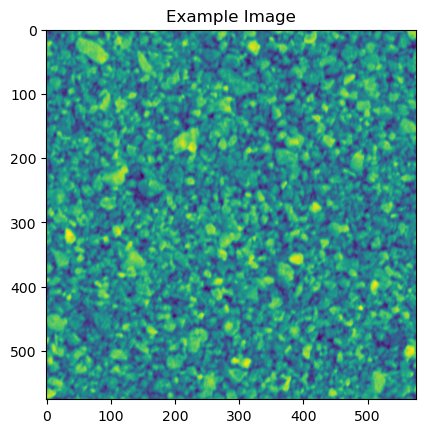

In [7]:
#display an image from the 'sand1' folder in the training dataset
example_image = train_df[train_df['label'] == 'sand1']['image'].iloc[0]

plt.imshow(example_image)
plt.title('Example Image')
plt.show()

## 1.2 Image Preprocessing

In [8]:
#function that build an image pyramid for each image with 3 levels [576×576, 228×228, 144×144].
def build_image_pyramid(images):
    
    Pyramid_Level_1=[]
    Pyramid_Level_2=[]
    Pyramid_Level_3=[]
    scaling_factor = 0.5

    for image in images:
        
        original = skimage.exposure.equalize_hist(image)
        Level_1 = skimage.filters.gaussian(original, sigma=1.0, multichannel=True)
        Level_2 = skimage.transform .rescale(Level_1, scale=scaling_factor, anti_aliasing=True)
        Level_3 = skimage.transform.rescale(Level_2, scale=scaling_factor, anti_aliasing=True)
        
        Pyramid_Level_1.append(Level_1)
        Pyramid_Level_2.append(Level_2)
        Pyramid_Level_3.append(Level_3)

    return Pyramid_Level_1,Pyramid_Level_2,Pyramid_Level_3

In [9]:
#add our three level in train_df and test_df
Level_1,Level_2,Level_3=build_image_pyramid(train_df.image)
train_df["Level_1"]=Level_1
train_df["Level_2"]=Level_2
train_df["Level_3"]=Level_3

Level_1,Level_2,Level_3=build_image_pyramid(test_df.image)
test_df["Level_1"]=Level_1
test_df["Level_2"]=Level_2
test_df["Level_3"]=Level_3

C:\Users\Lab 11\AppData\Local\Temp\ipykernel_3696\3884982668.py:12: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  Level_1 = skimage.filters.gaussian(original, sigma=1.0, multichannel=True)
C:\Users\Lab 11\AppData\Local\Temp\ipykernel_3696\3884982668.py:12: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  Level_1 = skimage.filters.gaussian(original, sigma=1.0, multichannel=True)


In [10]:
train_df

,label,image,Level_1,Level_2,Level_3
0,stone1,"[[101, 98, 96, 102, 110, 120, 130, 132, 138, 1...","[[0.28619146970400033, 0.26565571139365596, 0....","[[0.300958740823672, 0.3261621429184548, 0.426...","[[0.38576018127756745, 0.5193720160937751, 0.5..."
1,stone1,"[[168, 169, 165, 154, 143, 129, 117, 104, 100,...","[[0.8276914838617697, 0.8119275264726891, 0.78...","[[0.7949939460372968, 0.7280677513606567, 0.56...","[[0.7109100449455106, 0.5089594478443376, 0.46..."
2,stone1,"[[185, 171, 152, 149, 161, 169, 165, 175, 171,...","[[0.9087119130926065, 0.8533536550796726, 0.70...","[[0.8637659819745196, 0.6899872194332187, 0.82...","[[0.7850015728229154, 0.8703367791507133, 0.78..."
3,stone1,"[[140, 144, 141, 123, 117, 129, 141, 153, 158,...","[[0.6087550832897777, 0.652985926433667, 0.636...","[[0.6282052772256148, 0.5721645577473108, 0.42...","[[0.6512216731080342, 0.527690669175088, 0.603..."
4,stone1,"[[169, 159, 145, 147, 155, 161, 157, 151, 166,...","[[0.8535031119499271, 0.8101036965825414, 0.70...","[[0.8431624208023292, 0.7459027394341733, 0.76...","[[0.8324542460086863, 0.8017816904156903, 0.84..."
...,...,...,...,...,...
25,canvas1,"[[152, 149, 135, 117, 105, 115, 140, 152, 163,...","[[0.6370366711607403, 0.7250043756475584, 0.64...","[[0.5995456225958898, 0.539761465366308, 0.397...","[[0.41465504010060333, 0.5081637803345296, 0.4..."
26,canvas1,"[[127, 112, 106, 75, 62, 67, 60, 65, 93, 130, ...","[[0.5055886984444738, 0.4555202804798295, 0.41...","[[0.5118286368746405, 0.3348941793515732, 0.06...","[[0.4515338495030423, 0.16375713391200292, 0.3..."
27,canvas1,"[[100, 89, 74, 47, 36, 40, 56, 69, 69, 102, 13...","[[0.3146388394706945, 0.2693259696921805, 0.14...","[[0.35070299735062943, 0.13769252166013102, 0....","[[0.3355230407683706, 0.1974505198454754, 0.58..."
28,canvas1,"[[143, 112, 37, 53, 110, 121, 168, 155, 128, 1...","[[0.6595374219397958, 0.35150235530520146, 0.0...","[[0.4248892940075087, 0.04160995295960359, 0.3...","[[0.18043623236764078, 0.4733391115278641, 0.4..."


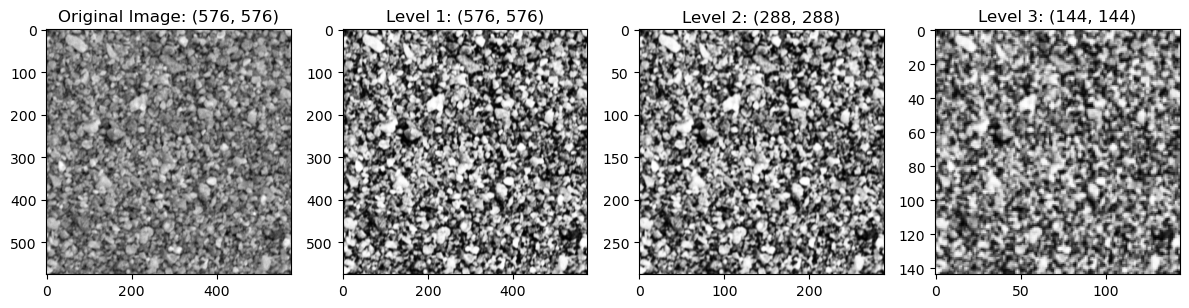

In [11]:
# display an image from the 'sand1' folder in the training dataset and its three levels with sizes
example_image = train_df[train_df['label'] == 'sand1']['image'].iloc[0]
example_level_1 = train_df[train_df['label'] == 'sand1']['Level_1'].iloc[0]
example_level_2 = train_df[train_df['label'] == 'sand1']['Level_2'].iloc[0]
example_level_3 = train_df[train_df['label'] == 'sand1']['Level_3'].iloc[0]

plt.figure(figsize=(12, 6))

plt.subplot(1, 4, 1)
plt.imshow(example_image, cmap='gray')
plt.title(f'Original Image: {example_image.shape[:2]}')

plt.subplot(1, 4, 2)
plt.imshow(example_level_1, cmap='gray')
plt.title(f'Level 1: {example_level_1.shape[:2]}')

plt.subplot(1, 4, 3)
plt.imshow(example_level_2, cmap='gray')
plt.title(f'Level 2: {example_level_2.shape[:2]}')

plt.subplot(1, 4, 4)
plt.imshow(example_level_3, cmap='gray')
plt.title(f'Level 3: {example_level_3.shape[:2]}')

plt.tight_layout()
plt.show()

In [12]:
#function that utilize the Sobel edge filter then summarize the filtered texture image by a histogram
def cal_sobel(Pyramid_Level_1):
    
    Histogram=[]
    for image in Pyramid_Level_1:
        sobel_image=sobel(image)
        hist, bins = np.histogram(sobel_image.flatten(), bins=256, range=(0, 1))
        Histogram.append(hist)
        
    return Histogram

In [13]:
#add our three histogram level in train_df and test_df
Histogram_1=cal_sobel(train_df.Level_1)
Histogram_2=cal_sobel(train_df.Level_2)
Histogram_3=cal_sobel(train_df.Level_3)
train_df["Histogram_1"]=Histogram_1
train_df["Histogram_2"]=Histogram_2
train_df["Histogram_3"]=Histogram_3

Histogram_1=cal_sobel(test_df.Level_1)
Histogram_2=cal_sobel(test_df.Level_2)
Histogram_3=cal_sobel(test_df.Level_3)
test_df["Histogram_1"]=Histogram_1
test_df["Histogram_2"]=Histogram_2
test_df["Histogram_3"]=Histogram_3

In [14]:
train_df

,label,image,Level_1,Level_2,Level_3,Histogram_1,Histogram_2,Histogram_3
0,stone1,"[[101, 98, 96, 102, 110, 120, 130, 132, 138, 1...","[[0.28619146970400033, 0.26565571139365596, 0....","[[0.300958740823672, 0.3261621429184548, 0.426...","[[0.38576018127756745, 0.5193720160937751, 0.5...","[2220, 4072, 5231, 5957, 6506, 6967, 7293, 762...","[138, 304, 461, 594, 707, 773, 847, 905, 1011,...","[9, 27, 51, 56, 75, 94, 99, 125, 141, 132, 156..."
1,stone1,"[[168, 169, 165, 154, 143, 129, 117, 104, 100,...","[[0.8276914838617697, 0.8119275264726891, 0.78...","[[0.7949939460372968, 0.7280677513606567, 0.56...","[[0.7109100449455106, 0.5089594478443376, 0.46...","[2049, 3858, 4858, 5465, 6044, 6508, 6823, 723...","[124, 312, 450, 563, 674, 785, 846, 891, 956, ...","[5, 25, 56, 66, 83, 117, 113, 113, 118, 166, 1..."
2,stone1,"[[185, 171, 152, 149, 161, 169, 165, 175, 171,...","[[0.9087119130926065, 0.8533536550796726, 0.70...","[[0.8637659819745196, 0.6899872194332187, 0.82...","[[0.7850015728229154, 0.8703367791507133, 0.78...","[1819, 3314, 4459, 5123, 5714, 6056, 6302, 676...","[112, 274, 377, 548, 660, 701, 827, 824, 924, ...","[6, 22, 46, 60, 72, 81, 115, 103, 140, 155, 15..."
3,stone1,"[[140, 144, 141, 123, 117, 129, 141, 153, 158,...","[[0.6087550832897777, 0.652985926433667, 0.636...","[[0.6282052772256148, 0.5721645577473108, 0.42...","[[0.6512216731080342, 0.527690669175088, 0.603...","[1800, 3469, 4320, 5077, 5528, 5915, 6292, 672...","[106, 282, 370, 509, 593, 726, 764, 844, 916, ...","[6, 28, 36, 60, 82, 97, 89, 118, 126, 148, 154..."
4,stone1,"[[169, 159, 145, 147, 155, 161, 157, 151, 166,...","[[0.8535031119499271, 0.8101036965825414, 0.70...","[[0.8431624208023292, 0.7459027394341733, 0.76...","[[0.8324542460086863, 0.8017816904156903, 0.84...","[2060, 3723, 4567, 5191, 5754, 6126, 6563, 673...","[128, 287, 457, 546, 615, 727, 818, 862, 961, ...","[11, 25, 57, 62, 80, 85, 81, 119, 151, 150, 17..."
...,...,...,...,...,...,...,...,...
25,canvas1,"[[152, 149, 135, 117, 105, 115, 140, 152, 163,...","[[0.6370366711607403, 0.7250043756475584, 0.64...","[[0.5995456225958898, 0.539761465366308, 0.397...","[[0.41465504010060333, 0.5081637803345296, 0.4...","[213, 594, 879, 1158, 1495, 1789, 2049, 2284, ...","[17, 67, 101, 159, 180, 260, 296, 356, 370, 42...","[11, 27, 41, 71, 74, 103, 115, 135, 144, 138, ..."
26,canvas1,"[[127, 112, 106, 75, 62, 67, 60, 65, 93, 130, ...","[[0.5055886984444738, 0.4555202804798295, 0.41...","[[0.5118286368746405, 0.3348941793515732, 0.06...","[[0.4515338495030423, 0.16375713391200292, 0.3...","[243, 610, 950, 1246, 1468, 1805, 2082, 2250, ...","[19, 67, 134, 168, 205, 261, 313, 342, 394, 42...","[8, 25, 38, 63, 89, 117, 107, 119, 160, 174, 1..."
27,canvas1,"[[100, 89, 74, 47, 36, 40, 56, 69, 69, 102, 13...","[[0.3146388394706945, 0.2693259696921805, 0.14...","[[0.35070299735062943, 0.13769252166013102, 0....","[[0.3355230407683706, 0.1974505198454754, 0.58...","[223, 544, 955, 1248, 1542, 1750, 2095, 2413, ...","[23, 80, 101, 189, 224, 296, 303, 376, 434, 47...","[6, 33, 46, 70, 89, 108, 114, 156, 149, 186, 1..."
28,canvas1,"[[143, 112, 37, 53, 110, 121, 168, 155, 128, 1...","[[0.6595374219397958, 0.35150235530520146, 0.0...","[[0.4248892940075087, 0.04160995295960359, 0.3...","[[0.18043623236764078, 0.4733391115278641, 0.4...","[247, 635, 988, 1288, 1515, 1853, 2097, 2383, ...","[21, 63, 133, 154, 246, 284, 331, 357, 415, 46...","[15, 27, 45, 57, 76, 94, 117, 147, 167, 176, 2..."


## 1.3 Learning-Free Classification

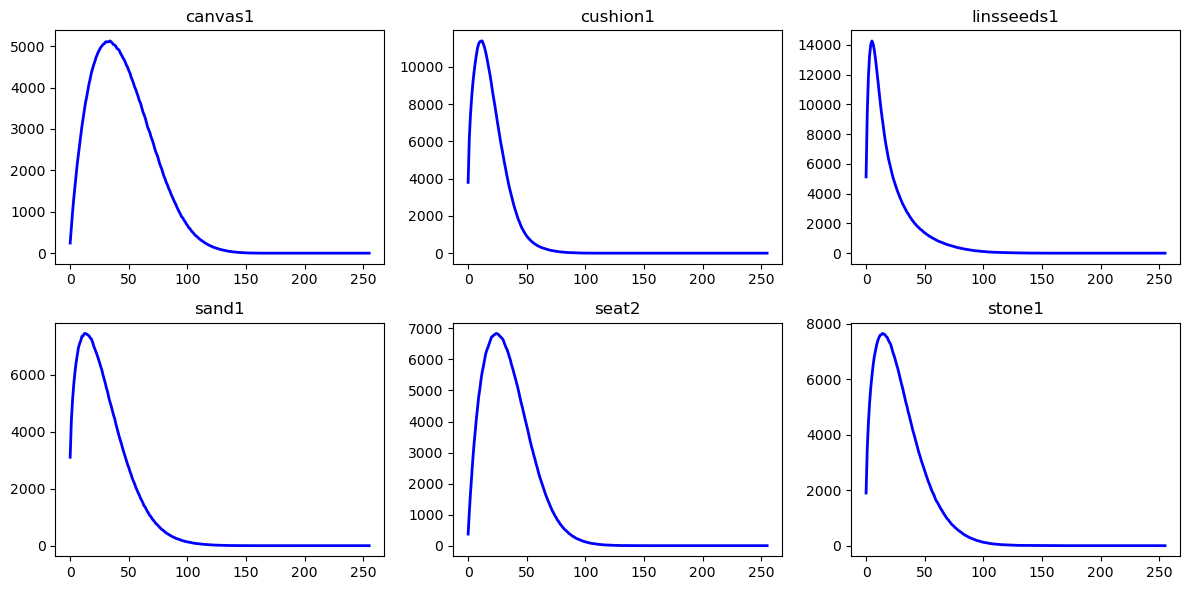

In [15]:
# Calculate the average histograms for each category in train_df and visulaize it
category_histograms = {}
for category in folders_to_load:
    category_histogram = np.zeros(256) 
    category_count = 0  
    
    for index, row in train_df.iterrows():
        if row['label'] == category:
            category_histogram += row['Histogram_1']
            category_count += 1
    
    category_histogram /= category_count
    category_histograms[category] = category_histogram

plt.figure(figsize=(12, 6))
for i, category in enumerate(folders_to_load):
    plt.subplot(2, 3, i + 1)
    plt.plot(category_histograms[category], color='b', linewidth=2)
    plt.title(category)
plt.tight_layout()
plt.show()

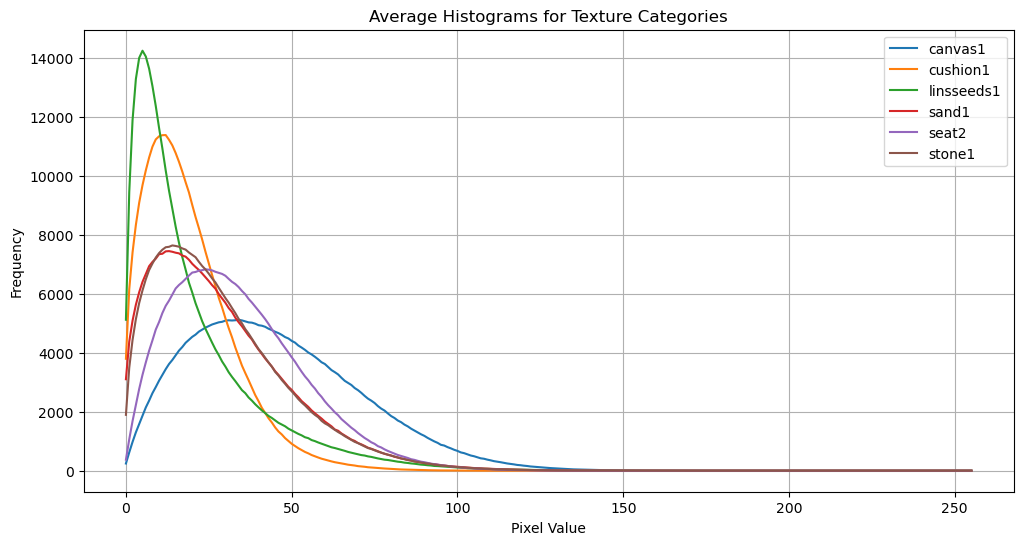

In [16]:
# Calculate the average histograms for each category in train_df and visulaize it in the same plot
category_histograms = {}
for category in folders_to_load:
    category_histogram = np.zeros(256)
    category_count = 0 
    
    for index, row in train_df.iterrows():
        if row['label'] == category:
            category_histogram += row['Histogram_1']
            category_count += 1
    
    category_histogram /= category_count
    category_histograms[category] = category_histogram

plt.figure(figsize=(12, 6))
for category in folders_to_load:
    plt.plot(category_histograms[category], label=category)
plt.title("Average Histograms for Texture Categories")
plt.xlabel("Pixel Value")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()

In [17]:
#split train_df to train_set and val_set
train_set = pd.DataFrame(columns=['label','image', 'Level_1', 'Level_2', 'Level_3', 'Histogram_1', 'Histogram_2', 'Histogram_3'])
val_set = pd.DataFrame(columns=['label','image', 'Level_1', 'Level_2', 'Level_3', 'Histogram_1', 'Histogram_2', 'Histogram_3'])

grouped = train_df.groupby('label')
for category, group_data in grouped:
    train_data, val_data = train_test_split(group_data, train_size=0.50 , random_state=42)
    train_set = pd.concat([train_set, train_data])
    val_set = pd.concat([val_set, val_data])

train_set.reset_index(drop=True, inplace=True)
val_set.reset_index(drop=True, inplace=True)

In [18]:
val_set

,label,image,Level_1,Level_2,Level_3,Histogram_1,Histogram_2,Histogram_3
0,canvas1,"[[100, 89, 74, 47, 36, 40, 56, 69, 69, 102, 13...","[[0.3146388394706945, 0.2693259696921805, 0.14...","[[0.35070299735062943, 0.13769252166013102, 0....","[[0.3355230407683706, 0.1974505198454754, 0.58...","[223, 544, 955, 1248, 1542, 1750, 2095, 2413, ...","[23, 80, 101, 189, 224, 296, 303, 376, 434, 47...","[6, 33, 46, 70, 89, 108, 114, 156, 149, 186, 1..."
1,canvas1,"[[174, 164, 138, 138, 130, 140, 142, 144, 205,...","[[0.8334828057877843, 0.7946460227419287, 0.66...","[[0.782934567786213, 0.7408662074744152, 0.739...","[[0.76442941663686, 0.7109644927758099, 0.5743...","[235, 544, 837, 1163, 1479, 1654, 1979, 2227, ...","[26, 86, 127, 177, 190, 255, 289, 355, 434, 42...","[10, 29, 42, 60, 96, 121, 118, 150, 169, 189, ..."
2,canvas1,"[[96, 157, 165, 169, 167, 140, 136, 169, 182, ...","[[0.3030495099001168, 0.7113163304093335, 0.74...","[[0.5349519448946379, 0.6987972119114313, 0.54...","[[0.5343053623201068, 0.47564658379307323, 0.5...","[202, 542, 935, 1210, 1476, 1775, 1982, 2238, ...","[31, 74, 110, 175, 247, 262, 334, 378, 385, 46...","[10, 34, 46, 81, 98, 110, 118, 141, 191, 199, ..."
3,canvas1,"[[67, 65, 67, 90, 110, 117, 119, 90, 79, 110, ...","[[0.06019225783616728, 0.06740328279355404, 0....","[[0.07264595637214476, 0.12631985966547687, 0....","[[0.19557317827278162, 0.3194249911574879, 0.5...","[338, 653, 1034, 1297, 1554, 1879, 2133, 2416,...","[18, 76, 113, 174, 199, 243, 296, 348, 392, 44...","[13, 27, 42, 66, 64, 112, 82, 126, 126, 177, 1..."
4,canvas1,"[[146, 125, 151, 164, 148, 125, 115, 123, 92, ...","[[0.6941757750340907, 0.5675658976378704, 0.74...","[[0.6369029086412311, 0.675471516660418, 0.475...","[[0.5721400771028836, 0.31885063493076066, 0.0...","[297, 735, 1170, 1574, 1771, 2120, 2424, 2710,...","[24, 75, 133, 188, 218, 281, 308, 349, 410, 45...","[8, 21, 48, 52, 61, 67, 115, 112, 131, 135, 15..."
...,...,...,...,...,...,...,...,...
85,stone1,"[[169, 159, 145, 147, 155, 161, 157, 151, 166,...","[[0.8535031119499271, 0.8101036965825414, 0.70...","[[0.8431624208023292, 0.7459027394341733, 0.76...","[[0.8324542460086863, 0.8017816904156903, 0.84...","[2060, 3723, 4567, 5191, 5754, 6126, 6563, 673...","[128, 287, 457, 546, 615, 727, 818, 862, 961, ...","[11, 25, 57, 62, 80, 85, 81, 119, 151, 150, 17..."
86,stone1,"[[129, 137, 138, 138, 150, 151, 146, 129, 120,...","[[0.5257638347545532, 0.5819311959066275, 0.61...","[[0.5663368920874304, 0.6382031453205932, 0.70...","[[0.6628930401271358, 0.5921848469231603, 0.31...","[2401, 4068, 4926, 5619, 6229, 6693, 7045, 723...","[147, 322, 467, 572, 714, 806, 873, 937, 927, ...","[11, 30, 49, 68, 83, 94, 99, 121, 136, 141, 15..."
87,stone1,"[[181, 189, 200, 203, 200, 199, 196, 188, 177,...","[[0.9249830586025831, 0.9535450727947217, 0.97...","[[0.9523197766019764, 0.9801216064256026, 0.96...","[[0.9729558654835941, 0.9458511325580894, 0.67...","[1793, 3440, 4565, 5256, 5903, 6259, 6589, 687...","[98, 262, 421, 527, 642, 713, 797, 871, 939, 1...","[7, 29, 45, 64, 94, 95, 99, 128, 147, 166, 158..."
88,stone1,"[[130, 149, 151, 150, 143, 145, 138, 140, 150,...","[[0.5508707457776527, 0.7340099066416517, 0.75...","[[0.686782970726165, 0.7634411634774823, 0.662...","[[0.7741023736214674, 0.56242516229095, 0.3862...","[1916, 3373, 4288, 4937, 5564, 5984, 6329, 660...","[133, 285, 430, 522, 638, 666, 735, 819, 896, ...","[13, 25, 57, 43, 88, 91, 85, 107, 125, 146, 16..."


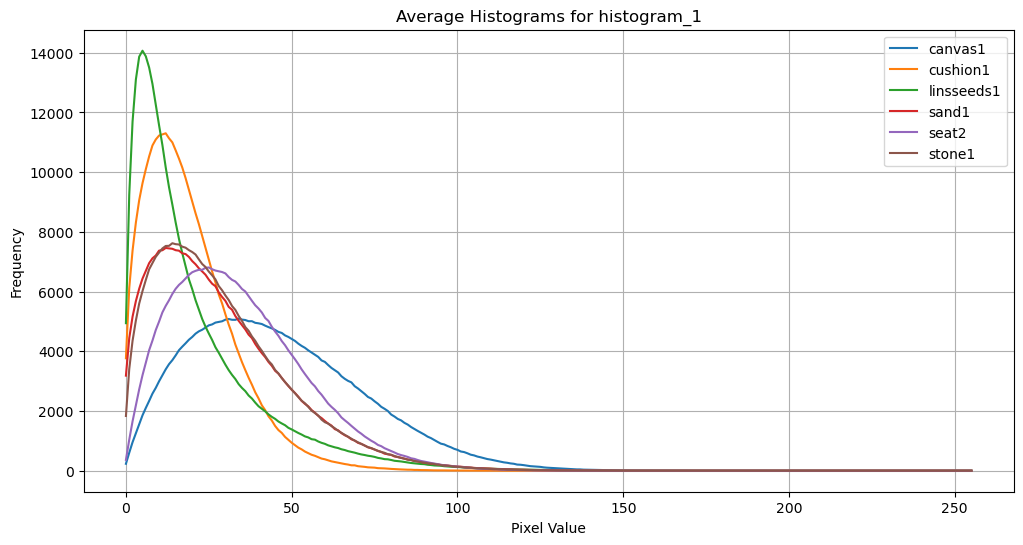

In [19]:
# Calculate the average histogram_1 for each category in train_set and visulaize it in the same plot
category_histograms = {}
for category in folders_to_load:
    category_histogram = np.zeros(256)
    category_count = 0
    
    for index, row in train_set.iterrows():
        if row['label'] == category:
            category_histogram += row['Histogram_1']
            category_count += 1
    
    category_histogram /= category_count
    category_histograms[category] = category_histogram

plt.figure(figsize=(12, 6))
for category in folders_to_load:
    plt.plot(category_histograms[category], label=category)
plt.title("Average Histograms for histogram_1")
plt.xlabel("Pixel Value")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()

In [20]:
# function to measure the distance between a given image histogram and the histogram for each class
def calculate_distance(image_histogram, category_histograms):
    distances = {}
    
    for category, category_histogram in category_histograms.items():
        distance = np.linalg.norm(image_histogram - category_histogram)
        distances[category] = distance
        
    return distances

example_image=val_set[val_set['label'] == 'sand1']['Histogram_1'].iloc[0]
distances = calculate_distance(example_image, category_histograms)
distances

{'canvas1': 18390.566484659103,
 'cushion1': 20701.87775637756,
 'linsseeds1': 26586.070087088006,
 'sand1': 3824.0486607782595,
 'seat2': 9858.124340867284,
 'stone1': 3582.103109130786}

In [21]:
# function to classify unseen images and return label_pred
def calculate_label_pred(Histogram_1, category_histograms):
    
    distances = {}
    label_pred=[]
    
    for image in Histogram_1:
        
        for category, category_histogram in category_histograms.items():
            distance = np.linalg.norm(image - category_histogram)
            distances[category] = distance
            
        min_category = min(distances, key=distances.get)
        label_pred.append(min_category)

    return label_pred

In [22]:
#add our "label_pred" in (train_set, val_set, test_df)
train_pred=calculate_label_pred(train_set.Histogram_1, category_histograms)
train_set["label_pred"]=train_pred

val_pred=calculate_label_pred(val_set.Histogram_1, category_histograms)
val_set["label_pred"]=val_pred

test_pred=calculate_label_pred(test_df.Histogram_1, category_histograms)
test_df["label_pred"]=test_pred

In [23]:
train_set

,label,image,Level_1,Level_2,Level_3,Histogram_1,Histogram_2,Histogram_3,label_pred
0,canvas1,"[[114, 184, 198, 152, 134, 148, 136, 92, 86, 9...","[[0.3418590751159046, 0.8454799988845753, 0.85...","[[0.5648085416797614, 0.6566751101305128, 0.63...","[[0.5407257845261516, 0.6056614443274326, 0.38...","[224, 535, 874, 1174, 1408, 1728, 1982, 2078, ...","[33, 91, 118, 160, 203, 285, 298, 362, 409, 45...","[18, 36, 53, 72, 87, 124, 145, 172, 186, 182, ...",canvas1
1,canvas1,"[[172, 154, 185, 197, 190, 137, 106, 91, 45, 4...","[[0.7633560991271882, 0.6995389937617862, 0.90...","[[0.6777235249984197, 0.8758077317507449, 0.79...","[[0.6540100745351418, 0.5320431997518066, 0.12...","[281, 729, 1156, 1569, 1912, 2339, 2507, 2869,...","[31, 78, 99, 160, 216, 250, 340, 366, 406, 467...","[7, 25, 33, 57, 63, 86, 107, 105, 140, 161, 18...",canvas1
2,canvas1,"[[176, 174, 162, 160, 155, 125, 95, 97, 85, 10...","[[0.8357780734694555, 0.8824304993345657, 0.85...","[[0.8276069264202494, 0.8431873494595434, 0.62...","[[0.7497990931886532, 0.5393241526447071, 0.44...","[307, 804, 1198, 1510, 1901, 2276, 2629, 2757,...","[30, 76, 131, 189, 237, 306, 323, 341, 435, 49...","[9, 24, 49, 42, 71, 105, 124, 136, 146, 149, 1...",canvas1
3,canvas1,"[[152, 149, 135, 117, 105, 115, 140, 152, 163,...","[[0.6370366711607403, 0.7250043756475584, 0.64...","[[0.5995456225958898, 0.539761465366308, 0.397...","[[0.41465504010060333, 0.5081637803345296, 0.4...","[213, 594, 879, 1158, 1495, 1789, 2049, 2284, ...","[17, 67, 101, 159, 180, 260, 296, 356, 370, 42...","[11, 27, 41, 71, 74, 103, 115, 135, 144, 138, ...",canvas1
4,canvas1,"[[136, 102, 106, 134, 127, 143, 209, 232, 239,...","[[0.5762604129600629, 0.29748773800301753, 0.4...","[[0.42271763784732475, 0.6454786511563019, 0.7...","[[0.5986899044858037, 0.872689358915655, 0.835...","[289, 730, 1092, 1448, 1719, 2187, 2367, 2634,...","[25, 84, 124, 184, 231, 305, 334, 384, 403, 42...","[7, 32, 46, 60, 75, 96, 127, 139, 141, 167, 17...",canvas1
...,...,...,...,...,...,...,...,...,...
85,stone1,"[[151, 142, 135, 140, 154, 148, 134, 134, 132,...","[[0.6709906196080553, 0.5958465856452946, 0.55...","[[0.5869156862550198, 0.5643305278035569, 0.65...","[[0.5608041356494631, 0.6376535139645366, 0.63...","[2333, 4159, 5143, 5797, 6293, 6832, 7263, 748...","[136, 353, 475, 565, 683, 776, 815, 975, 970, ...","[9, 23, 40, 69, 83, 91, 104, 129, 120, 132, 17...",stone1
86,stone1,"[[159, 205, 222, 213, 203, 192, 176, 130, 115,...","[[0.7033963792706104, 0.9301177489336556, 0.96...","[[0.7430183562306049, 0.9012619946101443, 0.90...","[[0.64503689509278, 0.7247114637829835, 0.3253...","[1788, 3247, 4276, 4796, 5505, 5874, 6176, 652...","[113, 298, 417, 508, 612, 673, 824, 885, 896, ...","[5, 33, 55, 63, 71, 98, 101, 119, 131, 161, 18...",stone1
87,stone1,"[[63, 66, 67, 79, 81, 68, 63, 64, 75, 93, 96, ...","[[0.061290541535651874, 0.0751445589222822, 0....","[[0.07995270955067794, 0.09679603025053302, 0....","[[0.15842166851651138, 0.08659736343275572, 0....","[1955, 3718, 4670, 5600, 6183, 6553, 6842, 702...","[103, 329, 431, 531, 667, 743, 814, 914, 968, ...","[8, 26, 34, 60, 86, 82, 104, 112, 113, 162, 17...",stone1
88,stone1,"[[100, 105, 120, 124, 121, 129, 133, 142, 143,...","[[0.24281990885643812, 0.29911135073529505, 0....","[[0.2679334037764935, 0.4957298060593882, 0.56...","[[0.3671124084650057, 0.5419165057052446, 0.33...","[1606, 2919, 3868, 4424, 5185, 5361, 5920, 621...","[118, 244, 377, 486, 570, 670, 773, 866, 860, ...","[7, 26, 42, 54, 73, 90, 104, 137, 141, 158, 16...",stone1


In [24]:
#compare actual and predicted label then compute (accuracy, recall, precision) for train_set and val_set
predicted = train_set['label_pred']
actual = train_set['label']

accuracy = accuracy_score(actual, predicted)
recall = recall_score(actual, predicted, average='weighted')  
precision = precision_score(actual, predicted, average='weighted')
 
print('Train results:')
print(f'Train Accuracy: {accuracy}')
print(f'Train Recall: {recall}')
print(f'Train Precision: {precision}')

predicted = val_set['label_pred']
actual = val_set['label']

accuracy = accuracy_score(actual, predicted)
recall = recall_score(actual, predicted, average='weighted')  
precision = precision_score(actual, predicted, average='weighted')

print('Val results:')
print(f'Val Accuracy: {accuracy}')
print(f'Val Recall: {recall}')
print(f'Val Precision: {precision}')

Train results:
Train Accuracy: 0.9777777777777777
Train Recall: 0.9777777777777777
Train Precision: 0.9803921568627451
Val results:
Val Accuracy: 0.9666666666666667
Val Recall: 0.9666666666666667
Val Precision: 0.9672619047619048


In [25]:
#function to compute classified_result
def classified_result(df, column1, column2, new_column_name):
    are_equal = []

    for i in range(len(df)):
        if df[column1].iloc[i] == df[column2].iloc[i]:
            are_equal.append(True)
        else:
            are_equal.append(False)

    df[new_column_name] = are_equal
    return df

In [26]:
#add our "are_equal" in (train_set, val_set, test_df)
train_set = classified_result(test_df, 'label', 'label_pred', 'are_equal')
val_set = classified_result(test_df, 'label', 'label_pred', 'are_equal')
test_df = classified_result(test_df, 'label', 'label_pred', 'are_equal')

In [27]:
train_set

,label,image,Level_1,Level_2,Level_3,Histogram_1,Histogram_2,Histogram_3,label_pred,are_equal
0,stone1,"[[113, 94, 83, 70, 58, 55, 52, 41, 39, 48, 60,...","[[0.3282921555817254, 0.188173786144048, 0.139...","[[0.21709693195083762, 0.117264810363329, 0.05...","[[0.1697051387192089, 0.07567758725045728, 0.0...","[1982, 3631, 4495, 5101, 5636, 6082, 6416, 670...","[115, 283, 402, 512, 631, 669, 750, 825, 895, ...","[10, 24, 40, 77, 88, 83, 99, 114, 127, 153, 16...",stone1,True
1,stone1,"[[103, 107, 113, 113, 103, 97, 96, 104, 114, 1...","[[0.2861651307841464, 0.2859330612613977, 0.32...","[[0.2849597205386645, 0.2916480210450995, 0.28...","[[0.259973055614511, 0.30820234069663055, 0.43...","[2264, 3775, 4727, 5437, 6120, 6505, 6836, 704...","[137, 296, 443, 540, 610, 729, 784, 833, 892, ...","[7, 38, 41, 60, 69, 73, 114, 120, 141, 148, 15...",stone1,True
2,stone1,"[[122, 114, 114, 98, 89, 101, 120, 125, 110, 1...","[[0.4767467405051211, 0.4291237015174967, 0.38...","[[0.48227958998384585, 0.3142558335735716, 0.1...","[[0.38857268232600795, 0.2392923316252638, 0.3...","[2684, 4269, 5133, 5878, 6485, 6889, 7421, 746...","[190, 351, 478, 596, 669, 851, 867, 925, 943, ...","[6, 32, 58, 59, 70, 80, 100, 121, 136, 168, 16...",sand1,False
3,stone1,"[[142, 147, 166, 179, 180, 179, 179, 179, 181,...","[[0.6107375619679671, 0.6767400908338543, 0.80...","[[0.6166591622740479, 0.8188014416000523, 0.91...","[[0.6321759990210937, 0.90674271709956, 0.8130...","[2330, 3962, 5023, 5759, 6228, 6870, 7229, 745...","[122, 349, 459, 614, 705, 819, 878, 937, 1012,...","[8, 28, 45, 70, 66, 119, 138, 121, 136, 147, 1...",sand1,False
4,stone1,"[[120, 123, 128, 139, 127, 104, 101, 105, 101,...","[[0.4151197483101967, 0.4416175340617381, 0.49...","[[0.4039377616263214, 0.5238599876201397, 0.44...","[[0.42255696973359036, 0.3877187395716949, 0.2...","[1839, 3327, 4463, 5070, 5620, 6102, 6461, 681...","[123, 282, 411, 536, 653, 679, 863, 853, 866, ...","[7, 28, 53, 53, 75, 84, 114, 137, 154, 135, 15...",stone1,True
5,stone1,"[[126, 116, 102, 110, 133, 155, 163, 166, 163,...","[[0.5365434815291461, 0.4330531962701502, 0.28...","[[0.5106817858154892, 0.34044144316050406, 0.6...","[[0.4672213423274768, 0.5510643872691955, 0.66...","[1577, 3027, 4076, 4751, 5165, 5708, 6061, 644...","[100, 249, 415, 504, 576, 628, 745, 810, 873, ...","[2, 30, 44, 60, 87, 96, 97, 125, 116, 147, 143...",stone1,True
6,stone1,"[[154, 143, 156, 129, 113, 120, 123, 116, 106,...","[[0.7491738489140991, 0.6794669166473194, 0.76...","[[0.7246634168064829, 0.6495355801675338, 0.41...","[[0.6467494112170834, 0.43848737350403466, 0.5...","[1976, 3358, 4263, 4848, 5370, 5950, 6352, 647...","[122, 276, 411, 523, 615, 746, 796, 829, 920, ...","[6, 25, 45, 58, 70, 68, 117, 116, 127, 146, 14...",stone1,True
7,stone1,"[[138, 137, 130, 117, 109, 115, 129, 134, 148,...","[[0.6179191406537592, 0.59280656983873, 0.5318...","[[0.5969227618112827, 0.4799057766009083, 0.46...","[[0.5303069227323027, 0.6014530627192863, 0.80...","[1908, 3663, 4635, 5309, 5803, 6258, 6692, 689...","[105, 296, 431, 598, 631, 684, 839, 856, 969, ...","[7, 37, 47, 68, 79, 87, 114, 122, 137, 150, 18...",stone1,True
8,stone1,"[[213, 232, 233, 222, 204, 170, 132, 114, 103,...","[[0.9877820326757374, 0.9986443569380854, 0.99...","[[0.9876521325883237, 0.9971458298995184, 0.92...","[[0.971275577069441, 0.7766824649210159, 0.413...","[2109, 3978, 5076, 5772, 6156, 6715, 7024, 745...","[121, 328, 492, 544, 658, 790, 861, 882, 949, ...","[6, 22, 47, 68, 79, 97, 117, 136, 128, 148, 16...",stone1,True
9,stone1,"[[142, 145, 148, 146, 145, 146, 143, 142, 131,...","[[0.6580016957697095, 0.678464265981725, 0.704...","[[0.6772022335380139, 0.7006085894872347, 0.69...","[[0.6576635331248236, 0.644128967207775, 0.454...","[2201, 3970, 5075, 5984, 6589, 7009, 7322, 782...","[125, 297, 470, 558, 696, 753, 843, 887, 974, ...","[14, 18, 41, 68, 74, 91, 112, 115, 136, 135, 1...",stone1,True


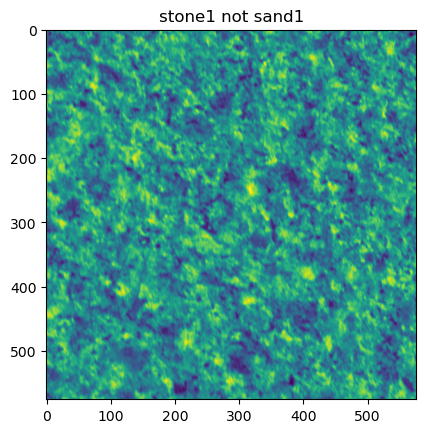

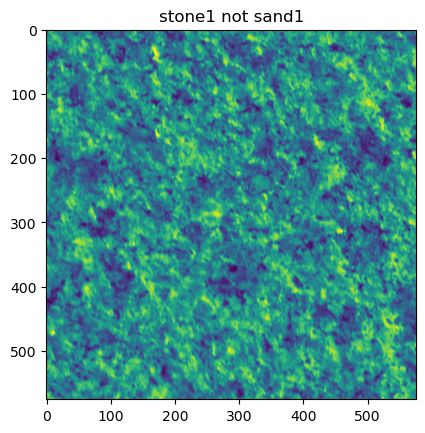

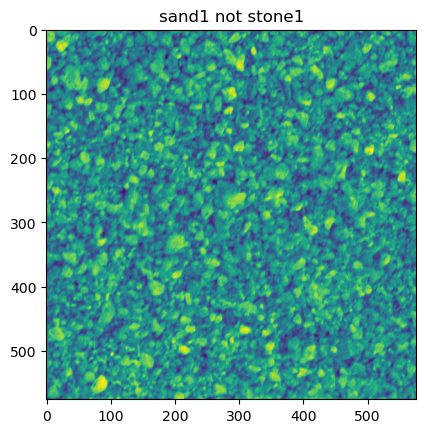

In [28]:
# Visualize all the miss-classified sample in val_set
for index, row in val_set.iterrows():
    if not row['are_equal']:
        example_image = row['image']
        plt.imshow(example_image)
        plt.title(f"{row['label']} not {row['label_pred']}")
        plt.show()

The accuracy above 90% on the validation set suggests that the model is performing well overall. 
However, all misclassifications occurring between 'sand1' and 'stone1' categories indicate that these two categories share similar visual features, making them challenging for the model to differentiate. 
This result suggests that all other categories are distinct from each other, but 'sand1' and 'stone1' are visually similar, leading to confusion in the classification. 
To address this, collecting more diverse data or using advanced feature extraction methods may be necessary to improve classification accuracy in these challenging cases.

## 1.4 Learning-Based Classification

In [29]:
# add 'Combined_Histogram' that combines the values from the three columns in (train_set, val_set, test_df)
def combine_histograms(row):
    return row['Histogram_1'] + row['Histogram_2'] + row['Histogram_3']

train_set['Combined_Histogram'] = train_set.apply(combine_histograms, axis=1)
val_set['Combined_Histogram'] = val_set.apply(combine_histograms, axis=1)
test_df['Combined_Histogram'] = test_df.apply(combine_histograms, axis=1)

In [30]:
train_set

,label,image,Level_1,Level_2,Level_3,Histogram_1,Histogram_2,Histogram_3,label_pred,are_equal,Combined_Histogram
0,stone1,"[[113, 94, 83, 70, 58, 55, 52, 41, 39, 48, 60,...","[[0.3282921555817254, 0.188173786144048, 0.139...","[[0.21709693195083762, 0.117264810363329, 0.05...","[[0.1697051387192089, 0.07567758725045728, 0.0...","[1982, 3631, 4495, 5101, 5636, 6082, 6416, 670...","[115, 283, 402, 512, 631, 669, 750, 825, 895, ...","[10, 24, 40, 77, 88, 83, 99, 114, 127, 153, 16...",stone1,True,"[2107, 3938, 4937, 5690, 6355, 6834, 7265, 764..."
1,stone1,"[[103, 107, 113, 113, 103, 97, 96, 104, 114, 1...","[[0.2861651307841464, 0.2859330612613977, 0.32...","[[0.2849597205386645, 0.2916480210450995, 0.28...","[[0.259973055614511, 0.30820234069663055, 0.43...","[2264, 3775, 4727, 5437, 6120, 6505, 6836, 704...","[137, 296, 443, 540, 610, 729, 784, 833, 892, ...","[7, 38, 41, 60, 69, 73, 114, 120, 141, 148, 15...",stone1,True,"[2408, 4109, 5211, 6037, 6799, 7307, 7734, 799..."
2,stone1,"[[122, 114, 114, 98, 89, 101, 120, 125, 110, 1...","[[0.4767467405051211, 0.4291237015174967, 0.38...","[[0.48227958998384585, 0.3142558335735716, 0.1...","[[0.38857268232600795, 0.2392923316252638, 0.3...","[2684, 4269, 5133, 5878, 6485, 6889, 7421, 746...","[190, 351, 478, 596, 669, 851, 867, 925, 943, ...","[6, 32, 58, 59, 70, 80, 100, 121, 136, 168, 16...",sand1,False,"[2880, 4652, 5669, 6533, 7224, 7820, 8388, 850..."
3,stone1,"[[142, 147, 166, 179, 180, 179, 179, 179, 181,...","[[0.6107375619679671, 0.6767400908338543, 0.80...","[[0.6166591622740479, 0.8188014416000523, 0.91...","[[0.6321759990210937, 0.90674271709956, 0.8130...","[2330, 3962, 5023, 5759, 6228, 6870, 7229, 745...","[122, 349, 459, 614, 705, 819, 878, 937, 1012,...","[8, 28, 45, 70, 66, 119, 138, 121, 136, 147, 1...",sand1,False,"[2460, 4339, 5527, 6443, 6999, 7808, 8245, 851..."
4,stone1,"[[120, 123, 128, 139, 127, 104, 101, 105, 101,...","[[0.4151197483101967, 0.4416175340617381, 0.49...","[[0.4039377616263214, 0.5238599876201397, 0.44...","[[0.42255696973359036, 0.3877187395716949, 0.2...","[1839, 3327, 4463, 5070, 5620, 6102, 6461, 681...","[123, 282, 411, 536, 653, 679, 863, 853, 866, ...","[7, 28, 53, 53, 75, 84, 114, 137, 154, 135, 15...",stone1,True,"[1969, 3637, 4927, 5659, 6348, 6865, 7438, 780..."
5,stone1,"[[126, 116, 102, 110, 133, 155, 163, 166, 163,...","[[0.5365434815291461, 0.4330531962701502, 0.28...","[[0.5106817858154892, 0.34044144316050406, 0.6...","[[0.4672213423274768, 0.5510643872691955, 0.66...","[1577, 3027, 4076, 4751, 5165, 5708, 6061, 644...","[100, 249, 415, 504, 576, 628, 745, 810, 873, ...","[2, 30, 44, 60, 87, 96, 97, 125, 116, 147, 143...",stone1,True,"[1679, 3306, 4535, 5315, 5828, 6432, 6903, 737..."
6,stone1,"[[154, 143, 156, 129, 113, 120, 123, 116, 106,...","[[0.7491738489140991, 0.6794669166473194, 0.76...","[[0.7246634168064829, 0.6495355801675338, 0.41...","[[0.6467494112170834, 0.43848737350403466, 0.5...","[1976, 3358, 4263, 4848, 5370, 5950, 6352, 647...","[122, 276, 411, 523, 615, 746, 796, 829, 920, ...","[6, 25, 45, 58, 70, 68, 117, 116, 127, 146, 14...",stone1,True,"[2104, 3659, 4719, 5429, 6055, 6764, 7265, 741..."
7,stone1,"[[138, 137, 130, 117, 109, 115, 129, 134, 148,...","[[0.6179191406537592, 0.59280656983873, 0.5318...","[[0.5969227618112827, 0.4799057766009083, 0.46...","[[0.5303069227323027, 0.6014530627192863, 0.80...","[1908, 3663, 4635, 5309, 5803, 6258, 6692, 689...","[105, 296, 431, 598, 631, 684, 839, 856, 969, ...","[7, 37, 47, 68, 79, 87, 114, 122, 137, 150, 18...",stone1,True,"[2020, 3996, 5113, 5975, 6513, 7029, 7645, 787..."
8,stone1,"[[213, 232, 233, 222, 204, 170, 132, 114, 103,...","[[0.9877820326757374, 0.9986443569380854, 0.99...","[[0.9876521325883237, 0.9971458298995184, 0.92...","[[0.971275577069441, 0.7766824649210159, 0.413...","[2109, 3978, 5076, 5772, 6156, 6715, 7024, 745...","[121, 328, 492, 544, 658, 790, 861, 882, 949, ...","[6, 22, 47, 68, 79, 97, 117, 136, 128, 148, 16...",stone1,True,"[2236

In [31]:
#Evaluate perceptron on both training set and validation set analyzing the accuracy, recall and precision.
x_train = train_set['Combined_Histogram']  
x_val = val_set['Combined_Histogram']  
x_test = test_df['Combined_Histogram']  

y_train = train_set['label']  
y_val = val_set['label']
y_test = test_df['label'] 

mlp = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=1000, random_state=42,validation_fraction=0.1)
mlp.fit(x_train.tolist(), y_train)

y_train_pred = mlp.predict(x_train.tolist())
y_val_pred = mlp.predict(x_val.tolist())

train_accuracy = accuracy_score(y_train, y_train_pred)
train_recall = recall_score(y_train, y_train_pred, average='weighted')
train_precision = precision_score(y_train, y_train_pred, average='weighted')

val_accuracy = accuracy_score(y_val, y_val_pred)
val_recall = recall_score(y_val, y_val_pred, average='weighted')
val_precision = precision_score(y_val, y_val_pred, average='weighted')

print("Training Set:")
print(f"Accuracy: {train_accuracy}")
print(f"Recall: {train_recall}")
print(f"Precision: {train_precision}")

print("\nValidation Set:")
print(f"Accuracy: {val_accuracy}")
print(f"Recall: {val_recall}")
print(f"Precision: {val_precision}")

Training Set:
Accuracy: 0.85
Recall: 0.85
Precision: 0.9035947712418301

Validation Set:
Accuracy: 0.85
Recall: 0.85
Precision: 0.9035947712418301


## 1.5 Classification Comparison

In [32]:
#the classifier of Sections 1.3 on test_df
predicted = test_df['label_pred']
actual = test_df['label']

# Compute accuracy, recall, and precision
accuracy = accuracy_score(actual, predicted)
recall = recall_score(actual, predicted, average='weighted')  
precision = precision_score(actual, predicted, average='weighted')

# Print the results
print("result of model 1.3:")
print(f'test Accuracy: {accuracy}')
print(f'test Recall: {recall}')
print(f'test Precision: {precision}')

result of model 1.3:
test Accuracy: 0.95
test Recall: 0.95
test Precision: 0.9511784511784512


In [33]:
#the classifier of Sections 1.4 on test_df
mlp = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=1000, random_state=42)
mlp.fit(x_train.tolist(), y_train)

# Make predictions on the training set and validation set
y_test_pred = mlp.predict(x_test.tolist())

# Evaluate the model on the validation set
test_accuracy = accuracy_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred, average='weighted')
test_precision = precision_score(y_test, y_test_pred, average='weighted')

print("result of model 1.4:")
print(f"Accuracy: {test_accuracy}")
print(f"Recall: {test_recall}")
print(f"Precision: {test_precision}")

result of model 1.4:
Accuracy: 0.85
Recall: 0.85
Precision: 0.9035947712418301


When comparing Model 1.3 and Model 1.4 on the test data subset, Model 1.3 achieves perfect performance but may lack generalization and robustness, potentially due to overfitting. Model 1.4, with slightly lower but strong performance, offers better generalization, requires less training effort, and is more robust, making it a preferable choice for real-world applications. The choice should depend on the specific application's needs for robustness and adaptability to unseen data.

## 1.6 Improved Classification

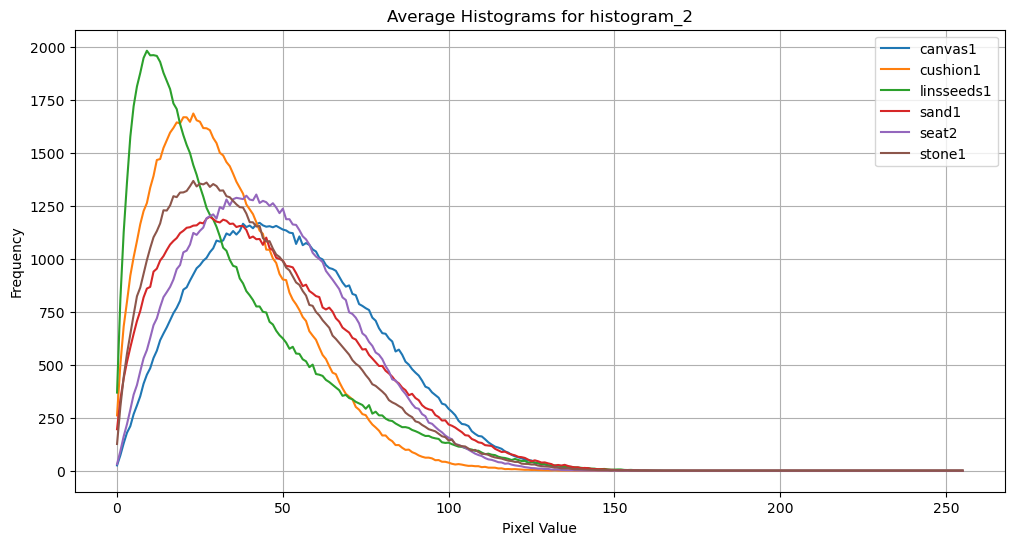

In [34]:
# Calculate the average histogram_2 for each category in train_set and visulaize it in the same plot
category_histograms = {}
for category in folders_to_load:
    category_histogram = np.zeros(256) 
    category_count = 0  
    

    for index, row in train_set.iterrows():
        if row['label'] == category:
            category_histogram += row['Histogram_2']
            category_count += 1
    
    category_histogram /= category_count
    category_histograms[category] = category_histogram

plt.figure(figsize=(12, 6))
for category in folders_to_load:
    plt.plot(category_histograms[category], label=category)
plt.title("Average Histograms for histogram_2")
plt.xlabel("Pixel Value")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()

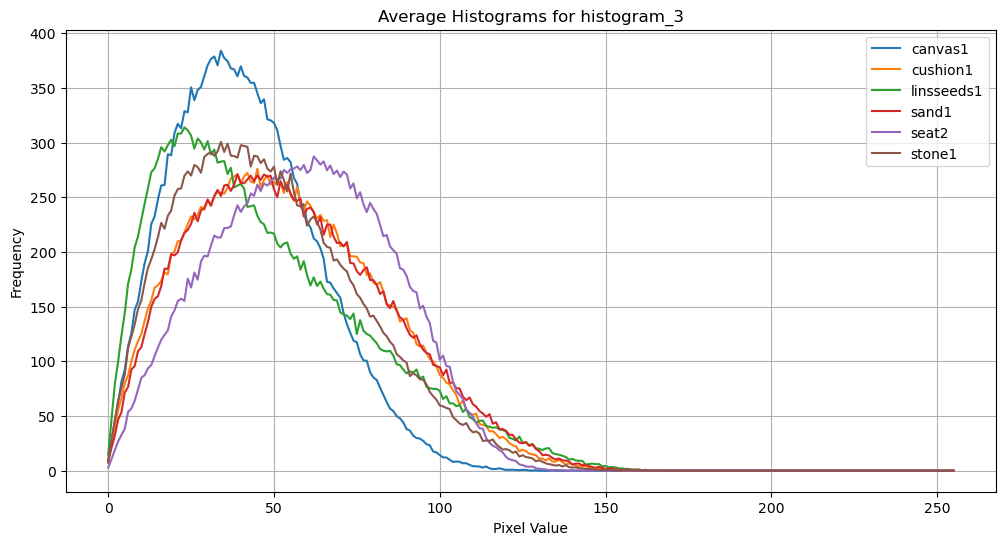

In [35]:
# Calculate the average histogram_3 for each category in train_set and visulaize it in the same plot
category_histograms = {}
for category in folders_to_load:
    category_histogram = np.zeros(256) 
    category_count = 0  
    

    for index, row in train_set.iterrows():
        if row['label'] == category:
            category_histogram += row['Histogram_3']
            category_count += 1
    
    category_histogram /= category_count
    category_histograms[category] = category_histogram

plt.figure(figsize=(12, 6))
for category in folders_to_load:
    plt.plot(category_histograms[category], label=category)
plt.title("Average Histograms for histogram_3")
plt.xlabel("Pixel Value")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()

In summary, expanding the image pyramid to include more levels can enhance performance by capturing diverse scales and improving robustness to illumination and noise. 
However, the decision should be weighed against factors like increased computational costs and potential diminishing returns, with data availability at various levels being a critical consideration.